# Data Migration: SQL Server to Postgres

In [1]:
import os
import pandas as pd
import pyodbc
import psycopg2
from psycopg2.extras import execute_values
from dotenv import load_dotenv

## 1. Load credentials


In [2]:
load_dotenv()

True

In [3]:
sql_host = os.getenv("SQL_SERVER_HOST")
sql_db = os.getenv("SQL_SERVER_DB")

In [4]:
print(f"SQL SERVER HOST: {sql_host}")
print(f"SQL SERVER DB: {sql_db}")

SQL SERVER HOST: LAPTOP-1O17LCQR\SQLEXPRESS
SQL SERVER DB: TransactionDB_UAT


In [5]:
pg_host = os.getenv("POSTGRES_HOST")
pg_port = os.getenv("POSTGRES_PORT")
pg_db = os.getenv("POSTGRES_DB")
pg_user = os.getenv("POSTGRES_USER")
pg_password = os.getenv("POSTGRES_PASSWORD")

In [6]:
print(f"POSGRES HOST: {pg_host}")
print(f"POSGRES PORT: {pg_port}")
print(f"POSGRES DB: {pg_db}")
print(f"POSGRES USER: {pg_user}")
print(f"POSGRES PASSWORD: {pg_password}")


POSGRES HOST: localhost
POSGRES PORT: 5432
POSGRES DB: transaction_uat
POSGRES USER: postgres
POSGRES PASSWORD: password


## 2. Connect to SQL Server

In [7]:
print("Connecting to SQL Server...")
print(f"   Server: {sql_host}")
print(f"   Database: {sql_db}")

Connecting to SQL Server...
   Server: LAPTOP-1O17LCQR\SQLEXPRESS
   Database: TransactionDB_UAT


In [8]:
try:
    sql_conn_string = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={sql_host};"
        f"DATABASE={sql_db};"
        f"Trusted_Connection=yes;"
    )

    sql_conn = pyodbc.connect(sql_conn_string)
    sql_cursor = sql_conn.cursor()
    print("[SUCCESS] -> Conenction to SQL Server now live! ")

except Exception as e:
    print(f"SQL Server connection failed: {e}")
    print(""" How to troubleshoot:
          > 1. Check server name in .env file is correct
          > 2. Verify SQL Server is running
          > 3. Check Windows Authentication is enabled 
            .... 
""")

[SUCCESS] -> Conenction to SQL Server now live! 


## 3. Connect to PostgreSQL

In [9]:
print("Connecting to PostgreSQL...")
print(f"   Server: {pg_host}")
print(f"   Database: {pg_db}")

Connecting to PostgreSQL...
   Server: localhost
   Database: transaction_uat


In [10]:
try:
    pg_conn = psycopg2.connect(
        host=pg_host,
        port=pg_port,
        database=pg_db,
        user=pg_user,
        password=pg_password
    )


    pg_cursor=pg_conn.cursor()
    pg_cursor.execute("SELECT version();")

    pg_version = pg_cursor.fetchone()[0]

    print("Connected to PostgreSQL")
    print(f"   Version: {pg_version[:50]}...\n")


except psycopg2.OperationalError as e:
    print(f" Postgres connection failed: {e}")
    print(""" How to troubleshoot:
            > 1. Check Postgres is running
            > 2. Verify username + password
            > 3. Check database exists
          
          ... 

""")

except Exception as e:
    print(f"Unexpected error: {e}")
    raise 

Connected to PostgreSQL
   Version: PostgreSQL 18.0 on x86_64-windows, compiled by msv...



## 4. Define the tables to migrate

### Migration order 

- Categories (no dependencies )
- Suppliers (no dependencies)
- Customers (no dependencies)
- Products (depends on Categories and Suppliers)

In [11]:
tables_to_migrate = ['Categories', 'Suppliers', 'Customers', 'Products']
print(tables_to_migrate)

['Categories', 'Suppliers', 'Customers', 'Products']


In [12]:
print("Table to migrate:")
for i, table in enumerate(tables_to_migrate, 1):
    print(f"   {i}. {table}")

total_no_tbls = len(tables_to_migrate)
print(f"\nTotal no of tables to migrate: {total_no_tbls}")

Table to migrate:
   1. Categories
   2. Suppliers
   3. Customers
   4. Products

Total no of tables to migrate: 4


## 5. Run pre-migration checks

In [13]:
print("=" * 50)
print(">>> Check 1: ROW COUNTS")
print("=" * 50)

>>> Check 1: ROW COUNTS


In [14]:
baseline_counts = {}


try:
    for table in tables_to_migrate:
        quoted_table = f"[{table}]"
        row_count_query = f"SELECT COUNT(*) as total_rows FROM {quoted_table}" 
        sql_cursor.execute(row_count_query)
        count = sql_cursor.fetchone()[0]

        baseline_counts[table] = count
        print(f"{table:15} {count:>12} rows")

    total_rows = sum(baseline_counts.values())
    print(f"{'-' * 30}")
    print(f"{'TOTAL':15} {total_rows:>12,} rows ")
    print("\n Baseline captured! ")

except Exception as e:
    print(f"Failed to get baseline counts: {e}")
    raise

Categories                 8 rows
Suppliers               5000 rows
Customers             900000 rows
Products              150000 rows
------------------------------
TOTAL              1,055,008 rows 

 Baseline captured! 


In [15]:
quality_issues = []

try:
    print("\nCHECK 2: NULL CHECKS (CustomerName)")
    sql_cursor.execute("""SELECT COUNT(*) AS null_count 
                          FROM Customers 
                          WHERE CustomerName IS NULL""")
    null_names = sql_cursor.fetchone()[0]
    if null_names > 0:
        quality_issues.append(f"    > {null_names:,} customers with NULL names...")
    # print(quality_issues)

    
    print("\nCHECK 3: INVALID EMAIL FORMATS CHECK")
    sql_cursor.execute("""SELECT COUNT(*) AS invalid_email_count 
                            FROM Customers 
                            WHERE Email LIKE '%@invalid'  """)
    invalid_emails = sql_cursor.fetchone()[0]
    if invalid_emails > 0:
        quality_issues.append(f"    > {invalid_emails:,} emails with invalid email formats...")
    # print(quality_issues)
    
    print("\nCHECK 4: NEGATIVE PRODUCT PRICES CHECK")
    sql_cursor.execute(""" SELECT COUNT(*) AS negative_product_prices_count 
                            FROM Products 
                            WHERE UnitPrice < 0
                       """)
    negative_price = sql_cursor.fetchone()[0]
    if negative_price > 0:
        quality_issues.append(f"    > {negative_price:,} prices contain negative prices...")
    # print(quality_issues)


    print("\nCHECK 5: NEGATIVE STOCK QUANTITIES CHECK")
    sql_cursor.execute(""" SELECT COUNT(*) AS negative_stock_quanities_count 
                            FROM Products 
                            WHERE StockQuantity < 0
                       """)
    negative_stock_quantities = sql_cursor.fetchone()[0]
    if negative_stock_quantities > 0:
        quality_issues.append(f"    > {negative_stock_quantities:,} products with negative stock...")
    # print(quality_issues)

    print("\nCHECK 6: ORPHANED FOREIGN KEYS CHECK")
    sql_cursor.execute(""" SELECT COUNT(*) AS orphaned_records 
                        FROM Products prod
                        WHERE NOT EXISTS (SELECT 1
                                            FROM Suppliers sup
                                            WHERE sup.SupplierID=prod.SupplierID)
""")
    orphaned_fks = sql_cursor.fetchone()[0]
    if orphaned_fks > 0:
        quality_issues.append(f"    > {orphaned_fks:,} products with orphaned foreign keys...")
    # print(quality_issues) 


    print("\nCHECK 7: FUTURES DATES CHECK")
    sql_cursor.execute(""" SELECT COUNT(*) as future_dates_count 
                            FROM Customers
                            WHERE CreatedDate > GETDATE()
""")
    future_dates = sql_cursor.fetchone()[0]
    if future_dates > 0:
        quality_issues.append(f"    > {future_dates:,} customers with future creations data later than current date...")
    # print(quality_issues)

    if quality_issues:
        print("\nData quality issues found (will migrate as-is)")
        for issue in quality_issues:
            print(issue)
    else:
        print("No data qualituy issues identified!")

except Exception as e:
    print(f"[ERROR] ===> Unexpected issue: {e}")
    raise


CHECK 2: NULL CHECKS (CustomerName)

CHECK 3: INVALID EMAIL FORMATS CHECK

CHECK 4: NEGATIVE PRODUCT PRICES CHECK

CHECK 5: NEGATIVE STOCK QUANTITIES CHECK

CHECK 6: ORPHANED FOREIGN KEYS CHECK

CHECK 7: FUTURES DATES CHECK

Data quality issues found (will migrate as-is)
    > 4,514 customers with NULL names...
    > 8,844 emails with invalid email formats...
    > 775 prices contain negative prices...
    > 1,467 products with negative stock...
    > 24,700 products with orphaned foreign keys...
    > 9,076 customers with future creations data later than current date...


## 6. Get table schema

In [16]:
print("=" * 65)
print("ANALYZE TABLE SCHEMA")
print("=" * 65)

ANALYZE TABLE SCHEMA


In [17]:
table_schema = {}


try:
    for table in tables_to_migrate:
        schema_query = f"""
            SELECT 
                COLUMN_NAME, 
                DATA_TYPE, 
                CHARACTER_MAXIMUM_LENGTH,
                IS_NULLABLE
            FROM 
                INFORMATION_SCHEMA.COLUMNS
            WHERE 
                table_name = '{table}'
            ORDER BY 
                ORDINAL_POSITION

"""
        schema_df = pd.read_sql(schema_query, sql_conn)
        print(f"\n{table}")
        print("-" * 10)
        print(schema_df)
        table_schema[table] = schema_df
        print("\n\n\n")



except Exception as e:
    pass


Categories
----------
    COLUMN_NAME DATA_TYPE  CHARACTER_MAXIMUM_LENGTH IS_NULLABLE
0    CategoryID       int                       NaN          NO
1  CategoryName  nvarchar                      50.0         YES
2   Description  nvarchar                      -1.0         YES





Suppliers
----------
    COLUMN_NAME DATA_TYPE  CHARACTER_MAXIMUM_LENGTH IS_NULLABLE
0    SupplierID       int                       NaN          NO
1  SupplierName  nvarchar                     150.0         YES
2   ContactName  nvarchar                     100.0         YES
3       Country  nvarchar                     100.0         YES
4         Phone  nvarchar                      20.0         YES





Customers
----------
    COLUMN_NAME DATA_TYPE  CHARACTER_MAXIMUM_LENGTH IS_NULLABLE
0    CustomerID       int                       NaN          NO
1  CustomerName  nvarchar                     100.0         YES
2         Email  nvarchar                     100.0         YES
3         Phone  nvarchar    

C:\Users\steph\AppData\Local\Temp\ipykernel_27836\3909585054.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schema_df = pd.read_sql(schema_query, sql_conn)
C:\Users\steph\AppData\Local\Temp\ipykernel_27836\3909585054.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schema_df = pd.read_sql(schema_query, sql_conn)
C:\Users\steph\AppData\Local\Temp\ipykernel_27836\3909585054.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schema_df = pd.read_sql(schema_query, sql_conn)
C:\Users\steph\AppData\Local\Temp\ipykernel

# 7. Define data type mappings

In [18]:
print("=" * 65)
print("DATA TYPE MAPPING")
print("=" * 65)

DATA TYPE MAPPING


In [19]:
type_mapping = {
    'int': 'INTEGER',
    'bigint': 'BIGINT',
    'smallint': 'SMALLINT',
    'tinyint': 'SMALLINT',
    'bit': 'BOOLEAN',
    'decimal': 'NUMERIC',
    'numeric': 'NUMERIC',
    'money': 'NUMERIC(19,4)',
    'smallmoney': 'NUMERIC(10,4)',
    'float': 'DOUBLE PRECISION',
    'real': 'REAL',
    'datetime': 'TIMESTAMP',
    'datetime2': 'TIMESTAMP',
    'smalldatetime': 'TIMESTAMP',
    'date': 'DATE',
    'time': 'TIME',
    'char': 'CHAR',
    'varchar': 'VARCHAR',
    'nchar': 'CHAR',
    'nvarchar': 'VARCHAR',
    'text': 'TEXT',
    'ntext': 'TEXT'
}

In [20]:
print("SQL Server to PostgreSQL type mapping ")
print()

for sql_type, pg_type in list(type_mapping.items()):
    print(f"    {sql_type:17} --->      {pg_type}")

SQL Server to PostgreSQL type mapping 

    int               --->      INTEGER
    bigint            --->      BIGINT
    smallint          --->      SMALLINT
    tinyint           --->      SMALLINT
    bit               --->      BOOLEAN
    decimal           --->      NUMERIC
    numeric           --->      NUMERIC
    money             --->      NUMERIC(19,4)
    smallmoney        --->      NUMERIC(10,4)
    float             --->      DOUBLE PRECISION
    real              --->      REAL
    datetime          --->      TIMESTAMP
    datetime2         --->      TIMESTAMP
    smalldatetime     --->      TIMESTAMP
    date              --->      DATE
    time              --->      TIME
    char              --->      CHAR
    varchar           --->      VARCHAR
    nchar             --->      CHAR
    nvarchar          --->      VARCHAR
    text              --->      TEXT
    ntext             --->      TEXT


## 8. Create tables in PostgreSQL

In [21]:
print("=" * 65)
print("CREATE TABLES IN POSTGRES")
print("=" * 65)

CREATE TABLES IN POSTGRES


In [22]:
try:
    for table in tables_to_migrate:

        schema = table_schema[table]

        pg_table = table.lower()

        pg_cursor.execute(f"DROP TABLE IF EXISTS {pg_table} CASCADE")

        column_definitions = []

        for idx, row in schema.iterrows():
            col_name = row['COLUMN_NAME'].lower()
            sql_type = row['DATA_TYPE']

            base_type = sql_type.lower()
            pg_type = type_mapping.get(base_type, 'TEXT')      

            condition_1 = idx == 0                      # Must be first column in the table
            condition_2 = col_name.endswith('id')       # Must end with ID
            condition_3 = 'int' in sql_type.lower()     # Must be INT data type

            if condition_1 and condition_2 and condition_3:
                column_definitions.append(f"{col_name} SERIAL PRIMARY KEY")
            else:
                column_definitions.append(f"{col_name} {pg_type}")

    
        column_string = ",\n        ".join(column_definitions)
        create_query =  f""" 
        CREATE TABLE {pg_table} (
            {column_string}
        )
        """

        pg_cursor.execute(create_query)
        pg_conn.commit()
    
    print("\n + " + "=" * 55)
    print("[SUCCESS] ---> All tables created successfully!")


except psycopg2.Error as e:
    print(f"Postgres experienced an error while creating a table: {e}")
    pg_conn.rollback()
    raise 


except Exception as e:
    print(f"Unexpected issue: {e}")

    


 + =======================================================
[SUCCESS] ---> All tables created successfully!


# 9. Test migration with one table

In [23]:
print("=" * 65)
print("TESTING MIGRATION (SINGLE TABLE)")
print("=" * 65)

TESTING MIGRATION (SINGLE TABLE)


In [24]:
test_table = 'Customers'
pg_table = test_table.lower()



In [25]:
try:
    print("1. Read from SQL Server... ")
    extract_query = f"SELECT * FROM {pg_table}"
    test_df = pd.read_sql(extract_query, sql_conn)

    print(f"        Read {len(test_df)} rows")


    print("2. Transforming data types...")

    if 'IsActive' in test_df.columns:
        test_df['IsActive'] = test_df['IsActive'].astype('bool')
        print("[SUCCESS] ---> Converted IsActive: BIT ---> BOOLEAN")


    print("3. Prepare the data for loading")
    data_tuples = [tuple(row) for row in test_df.to_numpy()]

    columns = [col.lower() for col in test_df.columns]

    columns_string = ', '.join(columns)

    placeholders = ', '.join(['%s'] * len(columns))

    insert_query = f"""
        INSERT INTO {pg_table} ({columns_string})
        VALUES %s
    """

    print(f"        Prepared {len(data_tuples):,} rows")


    print("4. Insert data into PostgreSQL...")
    execute_values(pg_cursor, insert_query, data_tuples, page_size=1000)
    pg_conn.commit()

    print(f"Loaded {len(data_tuples):,} rows")


    print("5. Verifying...")
    pg_cursor.execute(f"SELECT COUNT(*) AS total_rows FROM {pg_table}")
    pg_count = pg_cursor.fetchone()[0]

    sql_count = baseline_counts[test_table]

    if pg_count == sql_count:
        print(f"[SUCCESS] --> Verification passed: {pg_count:,} == {sql_count:,} ")
    else:
        print(f"[FAILED] --> Count mismatch: {pg_count:,} != {sql_count:,}")

    
    print(f"\n {test_table} migration test successfully completed!")



except Exception as e:
    pg_conn.rollback()
    raise

1. Read from SQL Server... 


C:\Users\steph\AppData\Local\Temp\ipykernel_27836\1989631993.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test_df = pd.read_sql(extract_query, sql_conn)


        Read 900000 rows
2. Transforming data types...
[SUCCESS] ---> Converted IsActive: BIT ---> BOOLEAN
3. Prepare the data for loading
        Prepared 900,000 rows
4. Insert data into PostgreSQL...
Loaded 900,000 rows
5. Verifying...
[SUCCESS] --> Verification passed: 900,000 == 900,000 

 Customers migration test successfully completed!


## 10. Migrate remaining tables

In [26]:
print("=" * 65)
print("MIGRATE REMAINING TABLES")
print("=" * 65)

MIGRATE REMAINING TABLES


In [27]:
remaining_tables = [t for t in tables_to_migrate if t != 'Customers']

for table in remaining_tables:
    pg_table = table.lower()

    print(f"Migrating {table} --> {pg_table}...")

    try:
        print("1. Reading from SQL Server...")
        extract_query = f"SELECT * FROM {table}"
        sql_df = pd.read_sql(extract_query, sql_conn)
        print(f"     Read {len(sql_df):,} rows\n\n")

        print("2. Preparing data...")
        data_tuples = [tuple(row) for row in sql_df.to_numpy()]
        columns = [col.lower() for col in sql_df.columns]
        columns_string = ', '.join(columns)
        insert_query = f"""
                INSERT INTO {pg_table} ({columns_string})
                VALUES %s
"""
        print(f"        Prepared {len(data_tuples):,} rows\n\n")


        print("3. Processing bulk load...")
        execute_values(pg_cursor, insert_query, data_tuples, page_size=1000)
        pg_conn.commit()

        print(f"[SUCCESS] ---> Loaded {len(data_tuples):,} rows\n\n")


        print("5. Verifying...")
        pg_cursor.execute(f"SELECT COUNT(*) AS total_rows FROM {pg_table}")
        pg_count = pg_cursor.fetchone()[0]

        sql_count = baseline_counts[table]

        if pg_count == sql_count:
            print(f"[SUCCESS] --> Verification passed: {pg_count:,} == {sql_count:,} ")
        else:
            print(f"[FAILED] --> Count mismatch: {pg_count:,} != {sql_count:,}")

        
        print(f"\n {table} migration successfully completed!")
        






    except Exception as e:
        print(f"Failed to migrate '{table}: {e}' ")
        pg_conn.rollback()
        raise

Migrating Categories --> categories...
1. Reading from SQL Server...
     Read 8 rows


2. Preparing data...
        Prepared 8 rows


3. Processing bulk load...
[SUCCESS] ---> Loaded 8 rows


5. Verifying...
[SUCCESS] --> Verification passed: 8 == 8 

 Categories migration successfully completed!
Migrating Suppliers --> suppliers...
1. Reading from SQL Server...
     Read 5,000 rows


2. Preparing data...
        Prepared 5,000 rows


3. Processing bulk load...
[SUCCESS] ---> Loaded 5,000 rows


5. Verifying...
[SUCCESS] --> Verification passed: 5,000 == 5,000 

 Suppliers migration successfully completed!
Migrating Products --> products...
1. Reading from SQL Server...


C:\Users\steph\AppData\Local\Temp\ipykernel_27836\3996697596.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_df = pd.read_sql(extract_query, sql_conn)


     Read 150,000 rows


2. Preparing data...
        Prepared 150,000 rows


3. Processing bulk load...
[SUCCESS] ---> Loaded 150,000 rows


5. Verifying...
[SUCCESS] --> Verification passed: 150,000 == 150,000 

 Products migration successfully completed!


# 11. Run post-migration validation

### -- 1. Row counts checks

##### SUCCESS: MATCHES SQL SERVER


### -- 2. Data type checks


##### SUCCESS: MATCHES SQL SERVER


### -- 3. Primary key checks (duplicates)


##### SUCCESS: MATCHES SQL SERVER


### -- 4. Referential integrity checks (duplicates)


##### SUCCESS: MATCHES SQL SERVER

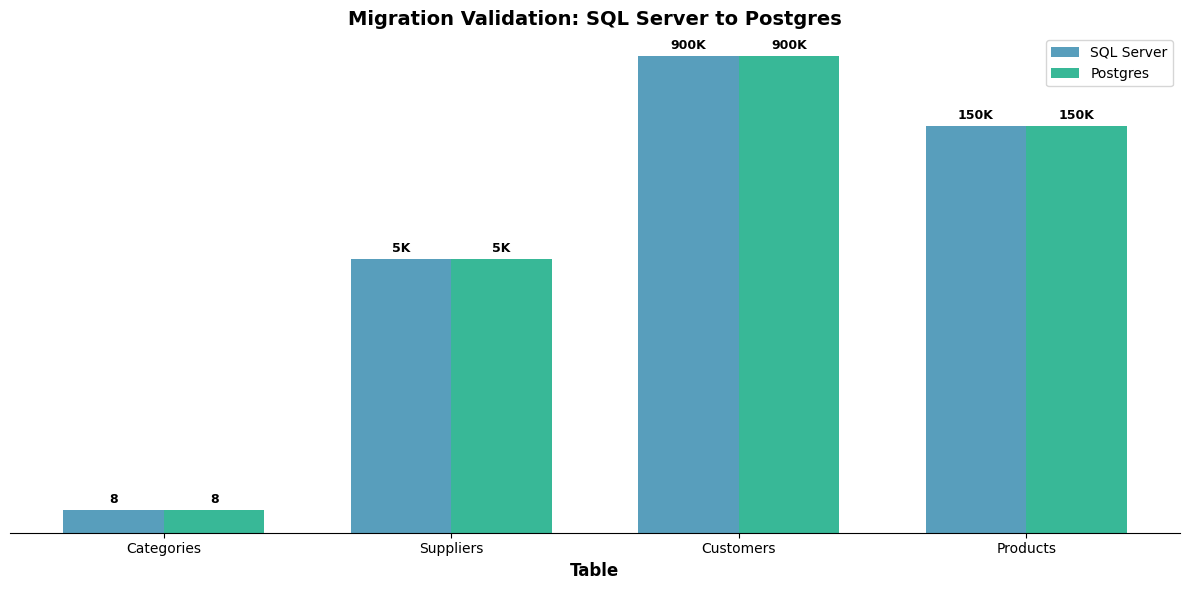

In [60]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

fig, ax = plt.subplots(figsize=(12, 6))


table_names = tables_to_migrate
sql_counts = [baseline_counts[t] for t in tables_to_migrate]

pg_counts = []
for table in tables_to_migrate:
    pg_cursor.execute(f"SELECT COUNT(*) FROM {table.lower()}")
    pg_counts.append(pg_cursor.fetchone()[0])

x = range(len(table_names))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], 
              sql_counts, 
              width, 
              label="SQL Server",
              color="#2e86ab",
              alpha=0.8)

bars2 = ax.bar([i + width/2 for i in x], 
              pg_counts, 
              width, 
              label="Postgres",
              color="#06a77d",
              alpha=0.8)

ax.set_xlabel('Table', fontweight='bold', fontsize=12)

ax.set_title('Migration Validation: SQL Server to Postgres', fontweight='bold', fontsize=14 )


ax.set_xticks(x)
ax.set_xticklabels(table_names)


ax.get_yaxis().set_visible(False) 
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_yscale('log')

ax.legend()


for bars in [bars1, bars2]:
    for bar in bars:

        height = bar.get_height()
        label = f"{int(height/1000)}K" if height >=1000 else f'{int(height)}'

        ax.text(bar.get_x() + bar.get_width()/2, 
                height * 1.1,
                label,
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold')

plt.tight_layout()
plt.show()


In [62]:
chart_name = 'migration_validation_chart.png'
plt.savefig(chart_name, dpi=150, bbox_inches='tight')
print(f"Chart saved: {chart_name} ")

Chart saved: migration_validation_chart.png 


<Figure size 640x480 with 0 Axes>